Say that there is the following *true* model---a 2D Gaussian with known width:

$$(x_1, x_2) \sim \mathcal{N}(\mu, \Sigma=0.25 I)$$

The true vector for the Gaussian is $\mu = (3, -1.5)$, which we are unaware of. We make 5 observations and attempt to reconstruct a posterior over $\mu$.

Furthermore, say that we don't know what the likelihood of a Gaussian is! We only know how to draw samples from a Gaussian: this is our "simulation."

#### How can we compute a distribution over $\mu$, without a likelihood?

## Likelihood-free Inference

For LFI, you need to provide two ingredients:

1. a prior distribution that allows to sample parameter sets (your guess at $\mu$)
2. a simulator that takes parameter sets and produces simulation outputs (samples of a Gaussian with a given $\mu$)

For example, let's pretend we have a reasonable idea that $\mu$ is within $[-10, 10]$ with uniform probability. We also have our simulator that generates samples of a Gaussian.

## Running the inference procedure

`sbi` provides a simple interface to run state-of-the-art algorithms for simulation-based inference.

# Getting started with `sbi`

In [140]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

Let's write out our uniform prior:

In [141]:
prior = utils.BoxUniform(
    low=torch.tensor([-10., -10.]),
    high=torch.tensor([10., 10.])
)


This will be used to generate proposals for $\mu$.

Now, let's write out our simulator for a given $\mu$:

In [142]:
def simulator(mu):
    # Generate samples from N(mu, sigma=0.5)
    
    return mu + 0.5 * torch.randn_like(mu)

Let's test it by inputting a vector of potential $\mu$ values:

In [143]:
simulator(
    torch.tensor([[1, 8.], [3., 5.], [-7., -3.]])
)

tensor([[ 0.7712,  7.8549],
        [ 3.0540,  6.0027],
        [-6.7873, -2.7240]])

So here are samples of each simulation. Now, we will use this simulator with Likelihood-Free Inference to construct a distribution over potential mu values:

#### Step 1: Let's learn a likelihood from the simulator:

The likelihood is a type of "normalized" Neural Network---called a "normalizing flow". (as an example check out my paper where we learn an accurate CMD straight from Gaia data with a normalizing flow: https://arxiv.org/abs/1908.08045)

In [144]:
prior

BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)

In [145]:
posterior = infer(
    simulator,
    prior,
    method='SNPE',
    num_simulations=1000)


Neural network successfully converged after 100 epochs.


Now we have a neural network that acts as our likelihood! Next, let's record our "observations" of the true distribution:

In [157]:
n_observations = 10
observation = torch.tensor([3., -1.5])[None] + 0.5*torch.randn(n_observations, 2)

In [158]:
import seaborn as sns
from matplotlib import pyplot as plt

Here's the data:

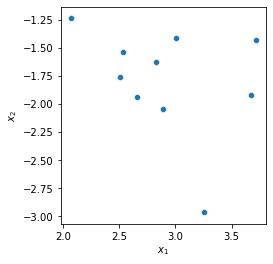

In [159]:
sns.scatterplot(x=observation[:, 0], y=observation[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.axis('scaled')
plt.show()

In [160]:
posterior.log_prob(samples, x=observation[0])

tensor([-4.3870, -4.2662, -4.1442,  ..., -2.6490, -2.6586, -2.6718])

We can now use our learned likelihood (a neural network) to do inference on $\mu$! The way the problem is structured on the neural net side, we need to manually include all observations separately. But we can make samples of a single datapoint like so:

In [161]:
samples = posterior.sample((10000,), x=observation[0])

And then plot this:

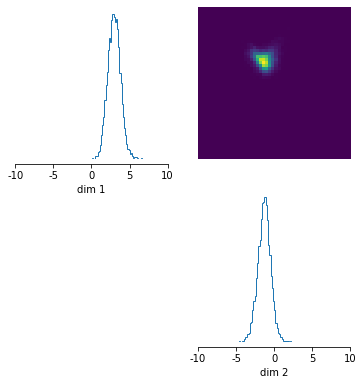

In [162]:

log_probability = posterior.log_prob(samples, x=observation[0])
out = utils.pairplot(samples, limits=[[-10,10],[-10,10]], fig_size=(6,6))


Let's create a grid of $\mu$ close to the expected value of $(3, -15)$, and calculate the total log likelihood for each value:

In [163]:
import numpy as np

bounds = [3-1, 3+1, -1.5-1, -1.5+1]

mu_1, mu_2 = torch.tensor(np.mgrid[bounds[0]:bounds[1]:2/50., bounds[2]:bounds[3]:2/50.]).float()

samples = torch.cat(
    (mu_1.reshape(-1, 1), mu_2.reshape(-1, 1)),
    dim=1
)


In [164]:
log_prob = sum([posterior.log_prob(samples, x=observation[i]) for i in range(len(observation))])
prob = torch.exp(log_prob)

In [165]:
# sns.pairplot()

(2.02, 3.98, -2.48, -0.52)

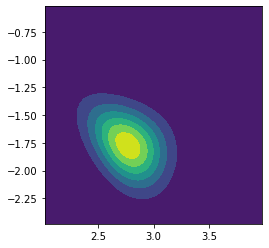

In [166]:
plt.contourf(prob.reshape(*mu_1.shape), extent=bounds, origin='lower')
plt.axis('scaled')

Now, this was a simple example and we could have written out an explicit likelihood. But the real power of Likelihood-Free Inference comes for high dimensional and complicated distributions, when there is no explicit analytic likelihood available. The exact same algorithm as above can simply be scaled up to a higher dimensional space.

## Requirements for the simulator, prior, and observation

Regardless of the algorithm you need to provide a prior and a simulator for training. Let's talk about what requirements they need to satisfy.


### Prior
A prior is a distribution object that allows to sample parameter sets. Any class for the prior is allowed as long as it allows to call `prior.sample()` and `prior.log_prob()`.

### Simulator
The simulator is a Python callable that takes in a parameter set and outputs data with some (even if very small) stochasticity.

Allowed data types and shapes for input and output:

- the input parameter set and the output have to be either a `np.ndarray` or a `torch.Tensor`. 
- the input parameter set should have either shape `(1,N)` or `(N)`, and the output must have shape `(1,M)` or `(M)`.

You can call simulators not written in Python as long as you wrap them in a Python function.

### Observation
Once you have a trained posterior, you will want to evaluate or sample the posterior $p(\theta|x_o)$ at certain observed values $x_o$:

- The allowable data types are either Numpy `np.ndarray` or a torch `torch.Tensor`.
- The shape must be either `(1,M)` or just `(M)`.

## Running different algorithms

`sbi` implements three classes of algorithms that can be used to obtain the posterior distribution: SNPE, SNLE, and SNRE. You can try the different algorithms by simply swapping out the `method`:

In [ ]:
posterior = infer(simulator, prior, method='SNPE', num_simulations=1000)
posterior = infer(simulator, prior, method='SNLE', num_simulations=1000)
posterior = infer(simulator, prior, method='SNRE', num_simulations=1000)

You can then infer, sample, evaluate, and plot the posterior as described above.